In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
from copy import deepcopy
import pickle as pkl

from ex_cosmology import p
from matplotlib import gridspec
import matplotlib.patches as mpatches

# adaptive-wavelets modules
import awave
from awave.data.cosmology import get_dataloader, load_pretrained_model
from awave.data.cosmology import get_validation
from awave.utils.misc import tuple_to_tensor
from awave.trim import TrimModel
from umap import UMAP

# evaluation
from eval_cosmology import load_results, rmse_bootstrap, extract_patches
from peak_counting import PeakCount

In [2]:
dirs = [
    "db5_saliency_warmstart_seed=1_new"
]
dics, results, models = load_results(dirs)

In [3]:
# get dataloader and model
train_loader, val_loader = get_dataloader(p.data_path,
                                          img_size=p.img_size[2],
                                          split_train_test=True,
                                          batch_size=p.batch_size)

model = load_pretrained_model(model_name='resnet18', device=device, data_path=p.model_path)

# validation dataset
test_loader = get_validation(p.data_path,
                             img_size=p.img_size[2],
                             batch_size=p.batch_size)

# Optimal wavelet

In [4]:
# # DB5
wt_o = awave.DWT2d(wave='db5', mode='zero', J=4,
                               init_factor=1, noise_factor=0, const_factor=0)

# load optimal wavelet for prediction on heldout dataset
bds = np.linspace(0.015, 0.035, 5)
scores = pkl.load(open('results/scores_new.pkl', 'rb'))
row, col = np.unravel_index(np.argmin(scores, axis=None), scores.shape)
bd_opt = bds[row]
idx1, idx2 = list(dics[0]['wt'].keys())[col + 1]  ## NEED TO CHECK
# idx2 = 4
wt = dics[0]['wt'][(idx1, idx2)].to('cpu')

In [5]:
X1_batch = []
X2_batch = []
y_test = []
for x,y in test_loader:
    X1_batch.append(wt(x))
    X2_batch.append(wt_o(x))
    y_test.append(y)
    
X1 = tuple()
X2 = tuple()
for idx in range(5):
    a = [x[idx] for x in X1_batch]
    X1 += (torch.cat(a, dim=0),)
    b = [x[idx] for x in X2_batch]
    X2 += (torch.cat(b, dim=0),)
y_test = torch.cat([a[:,1] for a in y_test], dim=0)

# umap
umap = UMAP(n_components=2, random_state=42)

# UMAP

In [6]:
# run t-SNE
batch_size = 2000
idx = 0
d1 = X1[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
d2 = X2[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
d = np.concatenate((d1,d2), axis=0)
embedding = umap.fit_transform(d)

# run t-SNE
idx = 1
d1 = X1[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
d2 = X2[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
d = np.concatenate((d1,d2), axis=0)
embedding2 = umap.fit_transform(d)

In [7]:
# run t-SNE
idx = 2
d1 = X1[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
d2 = X2[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
d = np.concatenate((d1,d2), axis=0)
embedding3 = umap.fit_transform(d)

In [8]:
# run t-SNE
idx = 3
d1 = X1[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
d2 = X2[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
d = np.concatenate((d1,d2), axis=0)
embedding4 = umap.fit_transform(d)

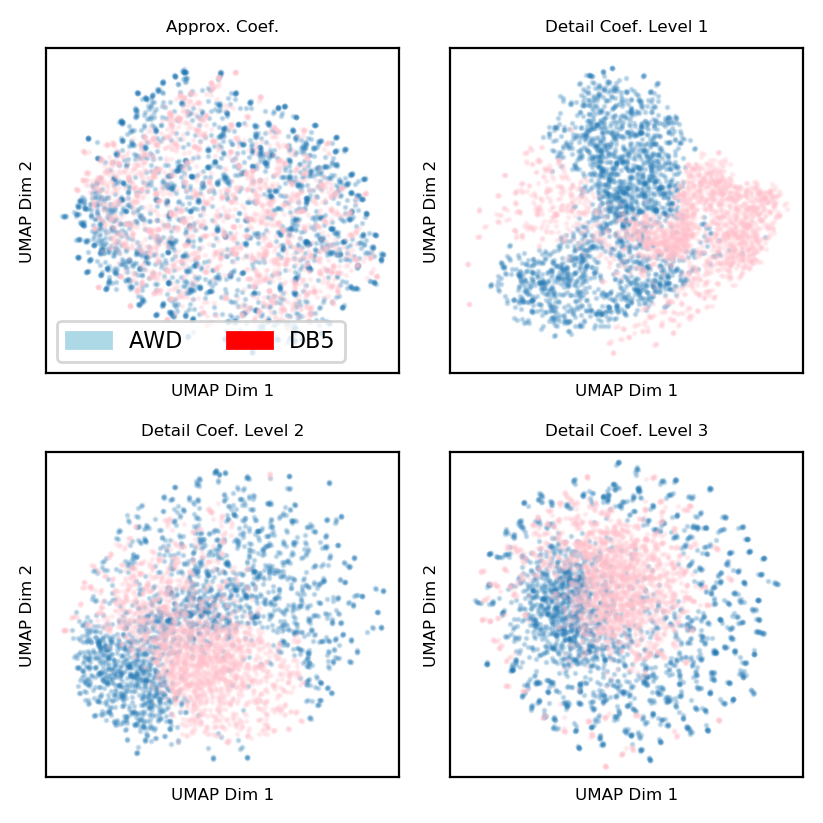

In [9]:
fig = plt.figure(constrained_layout=True, dpi=200, figsize=(4,4))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
colors = ['red', 'lightblue']
n = batch_size

# embedding1 vs embedding2
f_ax1 = fig.add_subplot(spec[0, 0])

h1 = plt.scatter(embedding[:n, 0], embedding[:n, 1], marker=".", s=5, alpha=0.2) #c=y_test, cmap='Blues')
h2 = plt.scatter(embedding[n:, 0], embedding[n:, 1], marker=".", s=5, c='pink', alpha=0.2) #y_test, cmap='Reds')            
plt.gca().set_aspect('equal', 'datalim')
blue_patch = mpatches.Patch(color='lightblue', label='AWD')
red_patch = mpatches.Patch(color='red', label='DB5')
plt.legend((h1, h2),
           ('AWD', 'DB5'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8,
           handles=(blue_patch, red_patch))
plt.title("Approx. Coef.", fontsize=6)
plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP Dim 1', fontsize=6)
plt.ylabel('UMAP Dim 2', fontsize=6)

# embedding1 vs embedding2
f_ax2 = fig.add_subplot(spec[0, 1])

b1 = plt.scatter(embedding2[:n, 0], embedding2[:n, 1], marker=".", s=5, alpha=0.2) #c=y_test, cmap='Blues')
b2 = plt.scatter(embedding2[n:, 0], embedding2[n:, 1], marker=".", s=5, c='pink', alpha=0.2) #y_test, cmap='Reds')             
plt.gca().set_aspect('equal', 'datalim')
# plt.legend()
plt.title("Detail Coef. Level 1", fontsize=6)
plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP Dim 1', fontsize=6)
plt.ylabel('UMAP Dim 2', fontsize=6)
# plt.colorbar(b1)

# embedding1 vs embedding2
f_ax3 = fig.add_subplot(spec[1, 0])

plt.scatter(embedding3[:n, 0], embedding3[:n, 1], marker=".", s=5, alpha=0.2) #c=y_test, cmap='Blues')
plt.scatter(embedding3[n:, 0], embedding3[n:, 1], marker=".", s=5, c='pink', alpha=0.2) #y_test, cmap='Reds')            
plt.gca().set_aspect('equal', 'datalim')
# plt.legend()
plt.title("Detail Coef. Level 2", fontsize=6)
plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP Dim 1', fontsize=6)
plt.ylabel('UMAP Dim 2', fontsize=6)

# embedding1 vs embedding2
f_ax4 = fig.add_subplot(spec[1, 1])

r1 = plt.scatter(embedding4[:n, 0], embedding4[:n, 1], marker=".", s=5, alpha=0.2) #c=y_test, cmap='Blues')
r2 = plt.scatter(embedding4[n:, 0], embedding4[n:, 1], marker=".", s=5, c='pink', alpha=0.2) #y_test, cmap='Reds')            
plt.gca().set_aspect('equal', 'datalim')
plt.title("Detail Coef. Level 3", fontsize=6)
plt.xticks([])
plt.yticks([])
# plt.colorbar(r2)
plt.xlabel('UMAP Dim 1', fontsize=6)
plt.ylabel('UMAP Dim 2', fontsize=6)

plt.show()